In [1]:
import numpy as np
from random import randint, random, choice
import matplotlib.pyplot as plt
from math import sqrt, log
import copy
%matplotlib inline

In [2]:
class Board(object):
    def __init__(self, num_players, rewards):
        self.n_players = num_players
        self.rewards = rewards
        self.grid = [[0 for i in range(4)] for j in range(4)]
        self.cur_turn = 1
        self.baseCamps = {2: [0, 0], 1: [3, 3]}
        self.this_turn_visited = []
        self.moves = {1: 0, 2: 0}
        self.last_moved = [None, None]
        self.starting_positions = {}
        self.prevInPlace = 0
        if self.n_players == 2: 
            self.starting_positions[1] = [[0, 0], [0, 1], [1, 0]] 
            self.starting_positions[2] = [[3, 3], [2, 3], [3, 2]] 
#         if self.cur_turn == 2:
#             self.opponentMove()
        
    def printBoard(self):
        for r in self.grid:
            print(r)
            
    def reset(self):
        self.grid = [[0 for i in range(4)] for j in range(4)]
        if self.n_players == 2: 
            for player, lst in self.starting_positions.items():
                 for x, y in lst:
                        self.grid[x][y] = player
    
    def checkWin(self, player):
        if self.n_players == 2:
            win_positions = self.starting_positions[self.n_players - player + 1]            
            for x, y in win_positions:
                if self.grid[x][y] != player:
                    return False
            return True
    
    def checkInPlace(self, reward = 10):
        piecesInPlace = 0
        if self.n_players == 2:
            win_positions = self.starting_positions[self.n_players - player + 1]            
            for x, y in win_positions:
                if self.grid[x][y] == player:
                    piecesInPlace += 100
            for i in range(len(self.grid)):
                for j in range(len(self.grid[i])):
                    if self.grid[i][j] == self.cur_turn:
                        totalDist += self.checkDist(i, j)
            return inPlaceDiff * reward
    
#     def calcTotalRew(self, reward = 10):
#         totalDist = 0.
#         for i in range(len(self.grid)):
#             for j in range(len(self.grid[i])):
#                 if self.grid[i][j] == self.cur_turn:
#                     totalDist += self.checkDist(i, j)
#         return totalDist*reward

    def calcTotalRew(self, reward = 10, player = None):
            if not player:
                player = self.cur_turn

            # The furthest we can possibly be in total
            maxDist = (len(self.grid))**2 + (len(self.grid))**2
            numPieces = len(self.starting_positions[player])
            maxTotalDist = maxDist*numPieces

            # The total distances of all pieces
            totalDist = 0.
            for i in range(len(self.grid)):
                for j in range(len(self.grid[i])):
                    if self.grid[i][j] == player:
                        totalDist += self.checkDist(i, j, player)

            # The further we are from being maximally far away
            # the higher our rewards will be
            invTotalDist = maxTotalDist - totalDist

            return invTotalDist*reward
                        
    def inBounds(self, i, j):
        if i < 0 or j < 0 or j > 3 or i > 3:
            return False
        return True
    
    def checkDist(self, x, y, other = None):
        if not other:
            other = self.baseCamps[3-self.cur_turn]

        baseX, baseY = other
        return ((baseY - y)**2 + (baseX-x)**2)
    
    def getLegalComplete(self, i, j, positive = None):
        # BFS from i, j
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
            return legal
        else:
            visited = [[False for q in range(4)] for z in range(4)]
            queue = [[i, j]]
            while queue:
                x, y = queue.pop(0)
                if not visited[x][y]:
                    if [x, y] != [i, j]:
                        legal["jumps"].append([x, y])
                    for k in range(-1, 2):
                        for l in range(-1, 2):
                            if self.inBounds(x + 2*k, y + 2*l) and self.grid[x + 2*k][y + 2*l] == 0 and self.grid[x + k][y + l] != 0:        
                                    if not visited[x + 2*k][y + 2*l]: 
                                        queue.append([x + 2*k, y + 2*l])
                    visited[x][y] = True        

            for k in range(-1, 2):
                    for l in range(-1, 2):                    
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            legal["moves"].append([i + k, j + l])
            return legal

    def getLegalCompleteDist(self, i, j, positive = None, dist = True):
        # BFS from i, j
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
#             print(i, j, self.grid[i])
#             print("Why are you trying to move a blank space?")
            return legal
        else:
            visited = [[False for q in range(4)] for z in range(4)]
            queue = [[i, j, self.checkDist(i, j, other = positive)]]
            while queue:
                x, y, d = queue.pop(0)
                if not visited[x][y]:
                    if [x, y] != [i, j]:
                        legal["jumps"].append([x, y, d])
                    for k in range(-1, 2):
                        for l in range(-1, 2):
                            myDist = self.checkDist(x, y, other = positive)
                            if self.inBounds(x + 2*k, y + 2*l) and self.grid[x + 2*k][y + 2*l] == 0 and self.grid[x + k][y + l] != 0:        
                                    if not visited[x + 2*k][y + 2*l]: 
                                        newDist = self.checkDist(x + 2*k, y + 2*l, other = positive)
                                        if ((not dist) or myDist > newDist):
                                            queue.append([x + 2*k, y + 2*l, newDist])
                    visited[x][y] = True        

            for k in range(-1, 2):
                    for l in range(-1, 2):  
                        myDist = self.checkDist(i, j, other = positive)
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            newDist = self.checkDist(i + k, j + l, other = positive)
                            if ((not dist) or myDist > newDist):
                                legal["moves"].append([i + k, j + l, newDist])
            return legal
            
    def getLegal(self, i, j, positive = None, jump = False):
        legal = {"moves": [], "jumps": []}
        if self.grid[i][j] == 0:
            print(i, j, self.grid[i])
            print("Why are you trying to move a blank space?")
            return legal
        else:
            for k in range(-1, 2):
                for l in range(-1, 2):
                    myDist = self.checkDist(i, j, other = positive)
                    if self.inBounds(i + 2*k, j + 2*l) and self.grid[i + 2*k][j + 2*l] == 0 \
                    and self.grid[i + k][j + l] != 0:
                        newDist = self.checkDist(i + 2*k, j + 2*l, other = positive)
                        if (myDist > newDist):
                            legal["jumps"].append([i + 2*k, j + 2*l, newDist])
                    if not jump:
                        if self.inBounds(i + k, j + l) and self.grid[i + k][j + l] == 0:
                            newDist = self.checkDist(i + k, j + l, other = positive)
                            if (myDist > newDist):
                                legal["moves"].append([i + k, j + l, newDist])
            return legal
        
            
    def checkLegal(self, player, i, j, k, l):
        if self.grid[k][l] != 0 or self.grid[i][j] != player:
#             if random() < 0.01:
#             print("You can't do that move")
#           #  print("Here's why. Grid at k, l isn't 0?:", k, l, self.grid[k][l], "Or at i, j, isn't player", player, i, j, self.grid[i][j])
#             print("Here's why. You tried this move: ", i, j, k, l, "and here is the grid:")
#             self.printBoard()
            return False
        else:
#             legal = self.getLegalComplete(i, j)
            # TODO - This currently doesn't work because the getLegal() above needs to be passed a proper 
            # value for "positive"
#             if [k, l] not in [[m[0], m[1]] for m in legal["moves"]] and \
#                 [k, l] not in [[m[0], m[1]] for m in legal["jumps"]]:
#                 print("Not legal move")
#                 print(i, j, k, l, legal)
#                 return False
            return True
            
    def move(self, player, i, j, k, l, pBoard = False):
        if self.checkLegal(player, i, j, k, l) == True and self.cur_turn == player:
#             print "WE FUCKEN MADE A MOVE with player", player, i, j, k, l
            self.grid[i][j] = 0
            self.grid[k][l] = player
            
#             # set last moved
#             self.last_moved = [k, l]
            
#             # record in our path
#             if self.this_turn_visited == []:
#                 self.this_turn_visited.append([i, j])
#             self.this_turn_visited.append([k, l])
            
#             # check if we're able to move again
#             new_moves = self.getLegal(k, l)
            
#             # end turn if we didn't just jump and there are still legal jumps, and we didn't just move one space
#             if not new_moves["jumps"] or (abs(k - i) != 2 and abs(l - j) != 2):
#                 self.cur_turn = 3 - self.cur_turn
#                 self.this_turn_visited = []
            self.cur_turn = 3 - self.cur_turn
            self.moves[player] += 1
            if pBoard:
                self.printBoard()
        else:
            print("WE FAILED TO MAKE A MOVE with player", player, self.checkLegal(player, i, j, k, l), self.cur_turn == player, i, j, k, l)
            self.cur_turn = 3 - self.cur_turn
        

In [3]:
board = Board(2, 0)
board.reset()
board.move(1, 0, 1, 0, 2)
board.printBoard()
print(board.getLegalComplete(0,0))

[1, 0, 1, 0]
[1, 0, 0, 0]
[0, 0, 0, 2]
[0, 0, 2, 2]
{'jumps': [[2, 0]], 'moves': [[0, 1], [1, 1]]}


In [4]:
class Agent(object):
    def __init__(self, board, ID, baseOrigin):
        self.ID = ID
        self.baseOrigin = baseOrigin
        self.board = board
        self.pieces = self.board.starting_positions[self.ID]
        self.overrideDist = False
    
    def updateBoard(self, board):
        self.board = board
    
    def findPieces(self, board):
        pieces = []
        for i in range(len(board.grid)):
            for j in range(len(board.grid[i])):
                if board.grid[i][j] == self.ID:
                    pieces.append([i, j])
        return pieces
    
    def distToOther(self, piece, other = None):
        if not other:
            other = self.baseOrigin
        baseX, baseY = other
        pieceX, pieceY = piece
        return ((baseY - pieceY)**2 + (baseX-pieceX)**2)**.5
    
    def bestPiece(self, distPieces = None, mp = None, dist = True): 
        if not distPieces:
            distPieces = sorted([[self.distToOther(piece), piece] for piece in self.pieces])

        for piece in distPieces:
            i, j = piece[1]
            legals = self.board.getLegalCompleteDist(i, j, positive = mp, dist = dist)
            if legals["jumps"] or legals["moves"]:
                return [(i, j), legals]
        return [False, False]
    
    def bestMove(self, eps = .2):            
        if self.overrideDist:
            # Find the pieces that are not in the right positions
            s = self.board.starting_positions[self.board.n_players-self.ID+1]
            missedPieces = [x for x in self.pieces if x not in s]
            
            # Find the first missing position
            missedPos = [x for x in s if x not in self.pieces]
            if not missedPos:
                print("Erroneous")
                return False
            mp = missedPos[0]
            
            # Calculate distances and find best move using those
            distPieces = sorted([[self.distToOther(piece, mp), piece] for piece in missedPieces], reverse=True)         
            piece, legals = self.bestPiece(distPieces = distPieces, mp = mp)
            if not piece or not legals:
                piece, legals = self.bestPiece(distPieces = distPieces, mp = mp, dist = False)            
        else:
            piece, legals = self.bestPiece()
        
        if not piece or not legals:
            return False
        
        if legals["jumps"]:
            distJumps = sorted(legals["jumps"], reverse=True, key=lambda i: i[2])
            if random() < eps:
                target = choice(distJumps)
            else:
                target = distJumps[0]
            return [piece[0], piece[1], target[0], target[1]]

        elif legals["moves"]:
            distMoves = sorted(legals["moves"], reverse=True, key=lambda i: i[2])
            if random() < eps:
                target = choice(distMoves)
            else:
                target = distMoves[0]
            return [piece[0], piece[1], target[0], target[1]]
        
        else:
            return False
    
    def move(self):
        move = self.bestMove()
        
        # If no move available, clearly we are in a deadlock
        if not move:
            self.overrideDist = True
            move = self.bestMove()
            if not move:
                return False
        
        # Make move on board and record pieces
#         print move
        i, j, k, l = move
        self.board.move(self.ID, i, j, k, l)
        self.pieces = self.findPieces(self.board)
        
        return move

In [5]:
board = Board(2, 0)
board.reset()
player = Agent(board, 1, [0, 0])
opponent = Agent(board, 2, [3, 3])
runs = 0
for i in range(100):
    if board.checkWin(1) or board.checkWin(2):
        print i
        runs = i
        break
    mv = player.move()

    mv = opponent.move()

    if i > 30:
        board.printBoard()
        print "-------"

10


In [6]:
moveRew = -.1
winRew = 2
def PlayGame(nplayers = 2):
    brd = Board(nplayers, 0)
    brd.reset()
    opponent = Agent(brd, 2, [15, 15])
    player = Agent(brd, 1, [0, 0])
    players = [player, opponent]
    
# #     for i in range(250):
# #         opponent.move()
# #         player.move()

    rewards = {1: [], 2: []}
    m, m1 = 0, 0
    c = 0
    while True:
        for p in players:
            # Check if game is ended
            if brd.checkWin(p.ID or c > 20):
                rewards[p.ID].append(winRew)
                return p, rewards
            p.move()
            rewards[p.ID].append(moveRew)
            brd = p.board
        c+=1

In [7]:
lol = PlayGame()

In [8]:
plays = 200

In [9]:
wins = {1: 0, 2: 0}
rews = {1: [], 2: []}
for i in range(plays):
    p, r = PlayGame()
    wins[p.ID] += 1
    rews[1].append(np.sum(r[1])*(float(i)**2/2000.) + random()*100)
    rews[2].append(np.sum(r[2])*(float(i)**2/2000.))
cumrews = {1: np.cumsum(rews[1]), 2: np.cumsum(rews[2])}

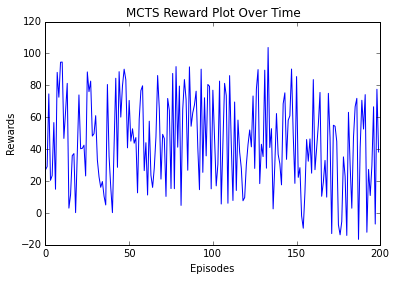

In [10]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[1][x], x)

plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("MCTS Reward Plot Over Time")
plt.plot(x, y)

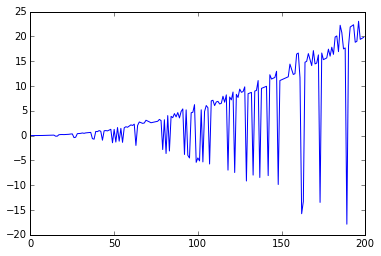

In [11]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[2][x], x)

plt.plot(x, y)

In [12]:
wins = {1: 0, 2: 0}
rews = {1: [], 2: []}
for i in range(plays):
    p, r = PlayGame()
    wins[p.ID] += 1
    rews[1].append(np.sum(r[1]))
    rews[2].append(np.sum(r[2]))
cumrews = {1: np.cumsum(rews[1]), 2: np.cumsum(rews[2])}

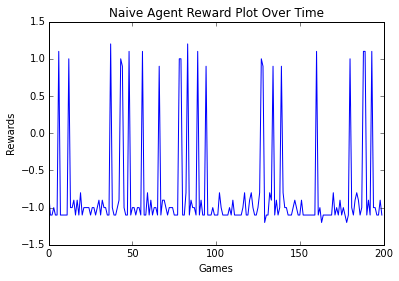

In [13]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[1][x], x)

plt.xlabel("Games")
plt.ylabel("Rewards")
plt.title("Naive Agent Reward Plot Over Time")
plt.plot(x, y)

In [14]:
class HalmaState:
    """ A state of the game of Halma
    """
    def __init__(self, players = 2, rewards = 0, opp = None):
        self.nplayers = 2
        self.rewards = 0
        self.board = Board(players, rewards)
        self.board.reset()
        self.opp = Agent(self.board, 2, [3, 3])
        self.size = len(self.board.grid)

    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = HalmaState()
        #st.board = copy.deepcopy(self.board)
        st.board.grid = [row[:] for row in self.board.grid]
#         st.board.grid = [self.board.grid[i][:] for i in range(len(self.board.grid))]
        #st.opp = copy.deepcopy(self.opp)
        st.opp =  Agent(st.board, 2, [3, 3])
#         print "CLONING IN PROGRESS"
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerJustMoved.
        """
        #self.board = copy.deepcopy(self.opp.board)
        self.board.grid = [row[:] for row in self.opp.board.grid]
        i, j, k, l = move
        if self.board.cur_turn != 1:
            print("something's wrong with cur_turn (should be 1)")
            
        self.board.move(1, i, j, k, l)
        #self.opp.board.move(1, i, j, k, l)
        
        if self.board.cur_turn != 2:
            print("something's wrong with cur_turn (should be 2)")
            
        self.opp.board.grid = [row[:] for row in self.board.grid]
        
        self.opp.pieces = self.opp.findPieces(self.opp.board)
        self.opp.move()
        #self.board.cur_turn = 3 - self.board.cur_turn
        
        # NEED TO CHECK IF THEY MOVED INTO A SPOT THAT WE HAVEN'T EXPLORED YET
        
        self.board.grid = [row[:] for row in self.opp.board.grid]

        if self.board.cur_turn != 1:
            print("something's wrong with cur_turn (should be 1) - step 2")
        
        if self.board.checkWin(1):
#             print 1, "WINS"
            return 1
        elif self.board.checkWin(2):
#             print 2, "WIINS"
            return 2
        else:
            return None        
    
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        moves = {"moves": [], "jumps": []}
        #self.board = copy.deepcopy(self.opp.board)
        self.board.grid = [row[:] for row in self.opp.board.grid]
        if self.board.checkWin(1) or self.board.checkWin(2):
#             print("what in the name of merlin")
            return moves
        for i in range(len(self.board.grid)):
            for j in range(len(self.board.grid)):
                if self.board.grid[i][j] == 1:
                    legals = self.board.getLegalComplete(i, j)
#                     if (legals["moves"] == [] and legals["jumps"] == []):
#                         print("something went wrong with legals")
#                         print(legals)
#                         legals = self.board.getLegalComplete(i, j, bitchTest = True)
#                         print(legals)
                    # remove places we've already traveled this turn if necessary
                    if legals["moves"]:
                        moves["moves"] += ([[i, j, k, l] for k, l in legals["moves"] if [i, j, k, l] not in moves["moves"]])
                    if legals["jumps"]:
                        moves["jumps"] += ([[i, j, k, l] for k, l in legals["jumps"] if [i, j, k, l] not in moves["jumps"]])
#         moves["moves"] = list(set(moves["moves"]))
#         moves["jumps"] = list(set(moves["jumps"]))
#         # Override
#         if not moves["moves"] and not moves["jumps"]:
#             # Find the pieces that are not in the right positions
#             s = self.board.starting_positions[3 - self.board.cur_turn]
            
#             # Find the first missing position
#             missedPos = [[x,y] for x, y in s if self.board.grid[x][y] == 0]
#             if missedPos:
#                 target = missedPos[0]
#             else:
#                 return moves
#             for i in range(len(self.board.grid)):
#                     if self.board.grid[i][j] == self.board.cur_turn:
#                         legals = self.board.getLegalComplete(i, j, positive = target)
#     #                     print legals, self.playerJustMoved, self.board.cur_turn

#                         # remove places we've already traveled this turn if necessary
#                         if legals["moves"]:
#                             moves["moves"] += ([[i, j, k, l] for k, l in legals["moves"] if [k, l] not in self.board.this_turn_visited])
#                         if legals["jumps"]:
#                             moves["jumps"] += ([[i, j, k, l] for k, l in legals["jumps"] if [k, l] not in self.board.this_turn_visited])
        
        if (moves["moves"] == [] and moves["jumps"] == []):
            print("something went wrong")
        return moves
    
    def GetResult(self, player):
        """ Get the game result from the viewpoint of playerjm. 
        """
        reward = 10
        #return self.board.checkInPlace(player, reward)
#         return self.board.calcTotalRew(reward)
#         return self.board.checkWin(player)*100 - self.board.moves[player]
        if self.board.checkWin(1):
            print("HORRAYYY")
            return 50 - self.board.moves[player]
        elif self.board.checkWin(2):
#             print 2, "WIINS"
            return -100

    def __repr__(self):
        s= ""
        for x in range(len(self.board.grid)):
            for y in range(len(self.board.grid[x])):
                s += ["[_]","[X]","[O]"][self.board.grid[x][y]]
            s += "\n"
        return s

In [15]:
class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, moveType = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.moveType = moveType
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.state = state
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.board.cur_turn # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        #print(sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits)))
        #self.untriedMoves = state.GetMoves()
        return s
    
    def AddChild(self, m, s, moveType = "moves"):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, moveType = moveType, parent = self, state = s)
        self.untriedMoves[moveType].remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
#         if result > 0:
#             print "booom"
        self.wins += result

    def __repr__(self):
        return "[M:" + str(self.move) + " MT:" + str(self.moveType) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s

In [16]:
def UCT(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for iters in range(itermax):
        node = rootnode
        state = rootstate.Clone()
        winner = None
#         print(iters)
        # Select
        while not node.untriedMoves["moves"] and not node.untriedMoves["jumps"] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            #print("THIS IS SELECTION")
            winner = state.DoMove(node.move)
            node.untriedMoves
            if winner:
                break
        
        # Expand
        #print("BOARD RIGHT BEFORE EXPANSION")
        #node.state.board.printBoard()
        if node.untriedMoves["moves"] or node.untriedMoves["jumps"] and not winner: # if we can expand (i.e. state/node is non-terminal)
            m = choice(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
            i, j, k, l = m
            #print("TEST")
            testing = 0
            while not state.board.checkLegal(1, i, j, k, l):
                
                m = choice(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
                i, j, k, l = m
                testing = testing + 1
                if testing == 500:
                    print(node.untriedMoves["moves"] + node.untriedMoves["jumps"])
                    node.state.board.printBoard()
                    print(node.state.board.cur_turn)
            #print("TEST1")
            
            #print("THIS IS EXPANSION", iters)
            winner = state.DoMove(m)
            if winner:
                break

            mt = "moves"
            if m in node.untriedMoves["jumps"]:
                mt = "jumps"
            node = node.AddChild(m, state, mt) # add child and descend tree
            #print("THIS IS END OF EXPANSION", iters)
        
        mvs = state.GetMoves()
        asdf = 0
        #print("BEGIN ROLLOUT")
        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        while mvs["moves"] or mvs["jumps"] and not winner: # while state is non-terminal
            mv = choice(mvs["moves"] + mvs["jumps"])
            i, j, k, l = mv
            testing = 0
            while not state.board.checkLegal(1, i, j, k, l):
                mv = choice(mvs["moves"] + mvs["jumps"])
                i, j, k, l = mv
                testing = testing + 1
                if testing > 500 and testing < 550:
                    print(mvs["moves"] + mvs["jumps"])
            
            if mv in mvs["moves"]:
                mvs["moves"].remove(mv)
            elif mv in mvs["jumps"]:
                mvs["jumps"].remove(mv)
            
            #print("THIS IS ROLLOUT")
            
            winner = state.DoMove(mv)
            if winner:
                break
            mvs = state.GetMoves()
        #print("ENDED ROLLOUT")
        
        if winner:
            node.childNodes = []
            node.untriedMoves = {"moves": [], "jumps": []}
        # Backpropagate
        #print("BEGIN BACKPROP")
        while node != None: # backpropagate from the expanded node and work back to the root node
            test = state.GetResult(node.playerJustMoved)
            if test > 0:
                print("SUCCESS")
            node.Update(test) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode
        #print("END BACKPROP")
        

#         if iters % 100 == 0:
#             print(iters)
        
#         if winner:
#             break 
    
    #print("EXITED")
#         if i > 2:
#             return

    # Output some information about the tree - can be omitted
    #if (verbose): print(rootnode.TreeToString(0))
    #else: print(rootnode.ChildrenToString())
    if not rootnode.childNodes:
        return rootnode.move
    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited

moveRew = -1
winRew = 100
def UCTPlayGame():
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    rewards = {1: [], 2: []}
    state = HalmaState()
    c = 0
    while (state.GetMoves()["jumps"] != [] or state.GetMoves()["moves"] != []):
        if c and not c%50:
            print(c)
            print(str(state))
            #print(state.board.calcTotalRew(10), state.board.cur_turn)
#         print(str(state))
        if state.board.cur_turn == 1:
            #print("BEGINNING PROCESS")
            m = UCT(rootstate = state, itermax = 2000, verbose = False) # play with values for itermax and verbose = True
            #print("ENDED PROCESS")
        else:
            print("WE SHOULDNT SEE THIS EVER")
#             m = UCT(rootstate = state, itermax = 2000, verbose = False)
#             m = opponent.move()
#             print("Best Move: " + str(m) + "\n")
        if m:
            state.DoMove(m)
#             if state.board.checkWin(1) or state.board.checkWin(2):
#                 print("Hallelujah")
            rewards[state.board.cur_turn].append(moveRew)
        else:
            print("premature break")
            break
        c+=1
#     print (state.GetMoves()["jumps"] != [] and state.GetMoves()["moves"] != [], state.GetMoves())
    if state.board.checkWin(1):
#         print("Player 1  wins!")
#         print(str(state))
#         print(c)
        rewards[1].append(winRew)
        return 1, rewards
    elif state.board.checkWin(2):
#         print("Player 2 wins!")
#         print(str(state))   
#print c
        rewards[2].append(winRew)
        return 2, rewards
    else:
        print("Fuck the castle")
        print(str(state))
        print(c)
        return 3-state.board.cur_turn, rewards

In [17]:
lol = UCTPlayGame()

HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS
HORRAYYY
SUCCESS


KeyboardInterrupt: 

In [142]:
plays = 10
wins = {1: 0, 2: 0}
rews = {1: [], 2: []}
for i in range(plays):
    p, r = UCTPlayGame()
    print(i)
    if p == 1:
        print("YAY")
    wins[p] += 1
    rews[1].append(np.sum(r[1]))
    rews[2].append(np.sum(r[2]))
cumrews = {1: np.cumsum(rews[1]), 2: np.cumsum(rews[2])}

0
1
2
3
4
5
6
7
8
9


ValueError: x and y must have same first dimension

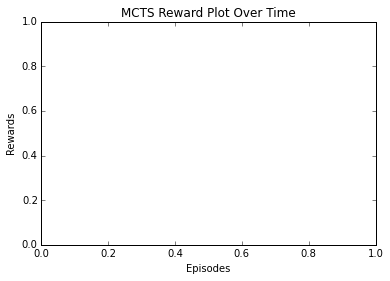

In [119]:
x = np.arange(0, plays, 1)
y = map(lambda x: rews[1][x], x)

plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("MCTS Reward Plot Over Time")
plt.plot(x, y)